# Lending Club Loan Portfolio — Data Cleaning & Exploration

**Aravalli Capital — Associate Assessment, Part 1**

This notebook ingests the Lending Club public loan dataset (~2.2M loans, 2007–2018 Q4), cleans and validates the data, and produces exploratory visualizations to support portfolio analytics, cash flow modeling, and scenario analysis.

---

## Table of Contents
1. [Setup & Imports](#1-setup)
2. [Load Raw Data](#2-load)
3. [Initial Exploration & Missingness](#3-explore)
4. [Data Type Conversions & Parsing](#4-parse)
5. [Loan Status Cleaning](#5-status)
6. [All-Loans Validation](#6-validate)
7. [Amortization Schedule Calculations](#7-amort)
8. [Current Loans Cleaning](#8-current)
9. [Late Loans Cleaning](#9-late)
10. [Default & Charged-Off Cleaning](#10-default)
11. [Final Column Cleaning](#11-final)
12. [Exploratory Visualizations & Credit Metrics](#12-metrics)
13. [Export Clean Dataset](#13-export)


---
<a id="1-setup"></a>
## 1. Setup & Imports


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ── Plot defaults ──────────────────────────────────────────────
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})

# ── Formatting helpers ─────────────────────────────────────────
def fmt_count(n):
    return f"{n:,.0f}"

def fmt_pct(x, _=None):
    return f"{x:.1f}%"

def fmt_dollar(x, _=None):
    if abs(x) >= 1e9:
        return f"${x/1e9:.1f}B"
    if abs(x) >= 1e6:
        return f"${x/1e6:.1f}M"
    return f"${x:,.0f}"

PALETTE = sns.color_palette("Set2", 10)
print("Setup complete.")


Setup complete.


---
<a id="2-load"></a>
## 2. Load Raw Data

The dataset comes from [Lending Club on Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club) and contains ~2.26 million accepted loans from 2007 through 2018 Q4. Each row is a single loan snapshot (not a time series).  
  
I referred to various sources and other people's projects to understand the data better and reduce the amount of assumptions I have to make. 
 * [LC's description of loan status](https://www.lendingclub.com/help/investing-faq/what-do-the-different-note-statuses-mean)
 * [An excel data dictionary containing descriptions of most of the columns](https://github.com/Rohini2505/Lending-Club-Loan-Analysis)
 * [Kaggle user project](https://www.kaggle.com/code/braindeadcoder/understanding-lending-club-s-data-with-eda)
 * [Other Kaggle user project](https://www.kaggle.com/code/pavlofesenko/minimizing-risks-for-loan-investments/notebook)

In [4]:
# ── CONFIGURE THIS PATH ─────────────────────────────────────────
DATA_PATH = r"C:\Users\gavro\OneDrive\Desktop\aravalli\data\accepted_2007_to_2018Q4.csv"

raw_df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Raw dataset: {raw_df.shape[0]:,} rows × {raw_df.shape[1]} columns")


Raw dataset: 2,260,701 rows × 151 columns


---
<a id="3-explore"></a>
## 3. Initial Exploration & Missingness

Before cleaning, let's understand what we're working with: shape, dtypes, and which columns are mostly null.


In [5]:
# Quick overview
print(f"Shape: {raw_df.shape}")
print(f"\nDtype breakdown:")
print(raw_df.dtypes.value_counts())
print(f"\nMemory usage: {raw_df.memory_usage(deep=True).sum() / 1e6:.0f} MB")


Shape: (2260701, 151)

Dtype breakdown:
float64    113
object      38
Name: count, dtype: int64

Memory usage: 6283 MB


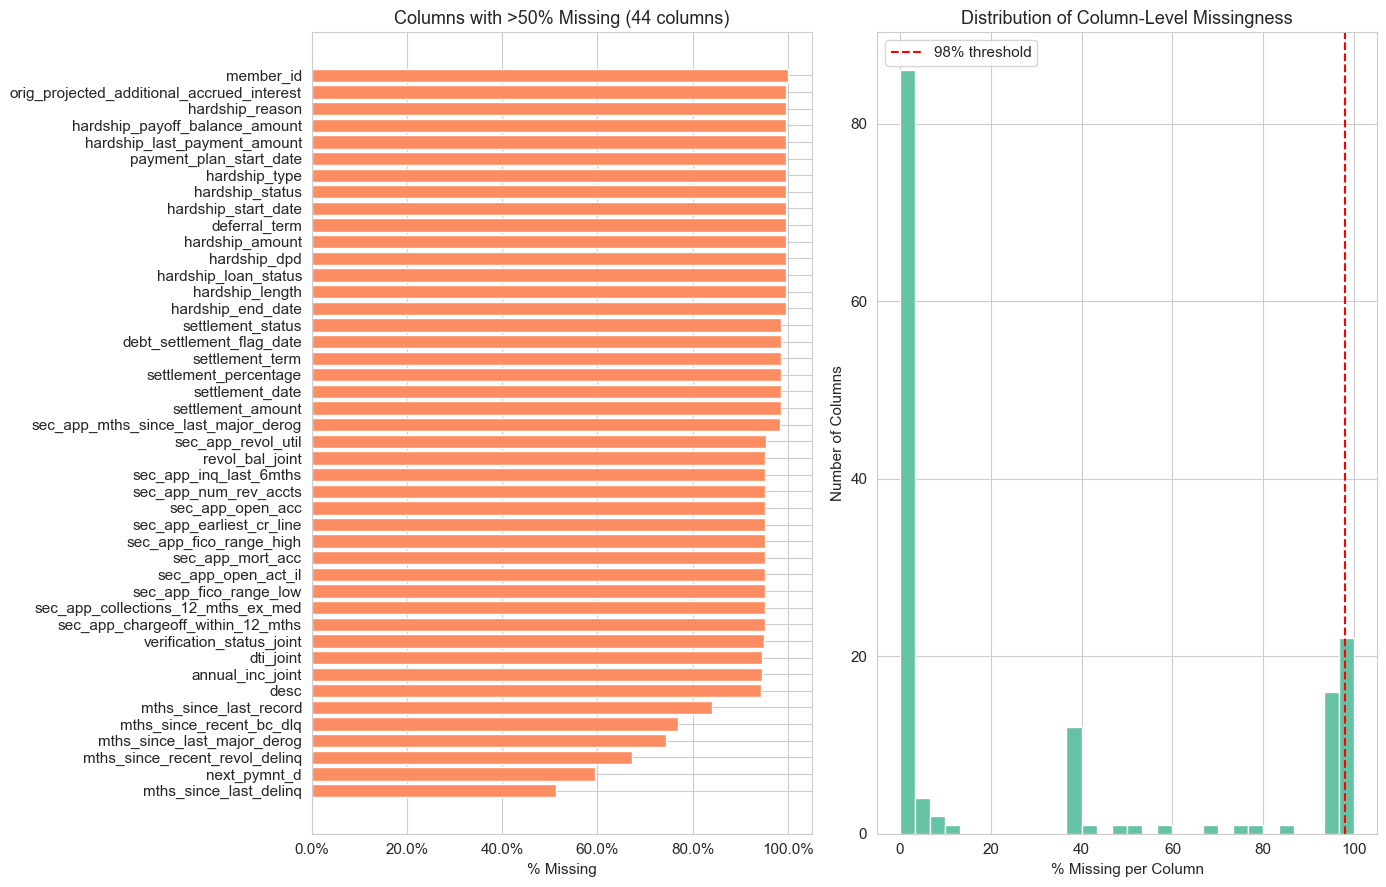

In [7]:
# ── Missingness heatmap ─────────────────────────────────────────
missing_frac = raw_df.isna().mean().sort_values(ascending=False)
high_missing = missing_frac[missing_frac > 0.5]

fig, axes = plt.subplots(1, 2, figsize=(14, 9))

# Left: bar chart of columns with >50% missing
axes[0].barh(
    high_missing.index[::-1],
    high_missing.values[::-1] * 100,
    color=PALETTE[1], edgecolor="white"
)
axes[0].set_xlabel("% Missing")
axes[0].set_title(f"Columns with >50% Missing ({len(high_missing)} columns)")
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(fmt_pct))

# Right: distribution of missingness across ALL columns
axes[1].hist(missing_frac.values * 100, bins=30, color=PALETTE[0], edgecolor="white")
axes[1].set_xlabel("% Missing per Column")
axes[1].set_ylabel("Number of Columns")
axes[1].set_title("Distribution of Column-Level Missingness")
axes[1].axvline(98, color="red", ls="--", lw=1.5, label="98% threshold")
axes[1].legend()

plt.tight_layout()
plt.show()


In [8]:
# ── Drop columns with ≥98% missing ─────────────────────────────
MISSING_THRESHOLD = 0.98

cols_to_drop = missing_frac[missing_frac >= MISSING_THRESHOLD].index.tolist()
print(f"Dropping {len(cols_to_drop)} columns with ≥{MISSING_THRESHOLD*100:.0f}% missing:")
for c in cols_to_drop:
    print(f"  • {c}  ({missing_frac[c]*100:.1f}%)")

df = raw_df.drop(columns=cols_to_drop).copy()
print(f"\nRemaining: {df.shape[0]:,} rows × {df.shape[1]} columns")


Dropping 22 columns with ≥98% missing:
  • member_id  (100.0%)
  • orig_projected_additional_accrued_interest  (99.6%)
  • hardship_reason  (99.5%)
  • hardship_payoff_balance_amount  (99.5%)
  • hardship_last_payment_amount  (99.5%)
  • payment_plan_start_date  (99.5%)
  • hardship_type  (99.5%)
  • hardship_status  (99.5%)
  • hardship_start_date  (99.5%)
  • deferral_term  (99.5%)
  • hardship_amount  (99.5%)
  • hardship_dpd  (99.5%)
  • hardship_loan_status  (99.5%)
  • hardship_length  (99.5%)
  • hardship_end_date  (99.5%)
  • settlement_status  (98.5%)
  • debt_settlement_flag_date  (98.5%)
  • settlement_term  (98.5%)
  • settlement_percentage  (98.5%)
  • settlement_date  (98.5%)
  • settlement_amount  (98.5%)
  • sec_app_mths_since_last_major_derog  (98.4%)

Remaining: 2,260,701 rows × 129 columns


---
<a id="4-parse"></a>
## 4. Data Type Conversions & Parsing

Key transformations:
- **id**: convert to integer, drop non-numeric rows (summary/policy rows in LC exports)
- **int_rate**: convert from percent (e.g. 13.56) to decimal (0.1356)
- **term**: extract numeric months from strings like `"36 months"`
- **Dates**: parse `issue_d`, `last_pymnt_d`, etc. from `"Dec-2015"` format
- **Derived**: `issue_quarter`, `maturity_month`


In [9]:
# ── 4a: Drop non-loan rows (non-numeric IDs) ──────────────────
df["id"] = pd.to_numeric(df["id"], errors="coerce")
n_before = len(df)
df = df.loc[df["id"].notna()].copy()
df["id"] = df["id"].astype("int64")
print(f"Dropped {n_before - len(df):,} non-loan rows (non-numeric IDs)")


Dropped 33 non-loan rows (non-numeric IDs)


In [10]:
# ── 4b: Interest rate — percent → decimal ──────────────────────
df["int_rate"] = pd.to_numeric(df["int_rate"], errors="coerce") / 100.0
print(f"Interest rate range: {df['int_rate'].min():.4f} – {df['int_rate'].max():.4f}")


Interest rate range: 0.0531 – 0.3099


In [11]:
# ── 4c: Parse date columns ─────────────────────────────────────
date_cols = ["issue_d", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Derived date columns
df["issue_month_year"] = df["issue_d"].dt.strftime("%b-%Y")
df["issue_quarter"] = df["issue_d"].dt.to_period("Q").astype(str)

print("Date ranges:")
for col in date_cols:
    if col in df.columns:
        print(f"  {col}: {df[col].min()} → {df[col].max()}")


Date ranges:
  issue_d: 2007-06-01 00:00:00 → 2018-12-01 00:00:00
  last_pymnt_d: 2007-12-01 00:00:00 → 2019-03-01 00:00:00
  last_credit_pull_d: 2007-05-01 00:00:00 → 2019-04-01 00:00:00
  next_pymnt_d: 2008-01-01 00:00:00 → 2019-05-01 00:00:00


In [12]:
# ── 4d: Term — extract numeric months ──────────────────────────
df["term_months"] = (
    df["term"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype("Int64")
)
print(f"Term values: {sorted(df['term_months'].dropna().unique())}")


Term values: [np.int64(36), np.int64(60)]


In [13]:
# ── 4e: Maturity month ─────────────────────────────────────────
df["maturity_month"] = df["issue_d"].dt.to_period("M") + df["term_months"]

print(f"\nParsed dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")



Parsed dataset: 2,260,668 rows × 133 columns


### Visualization: Origination Volume & Interest Rates Over Time

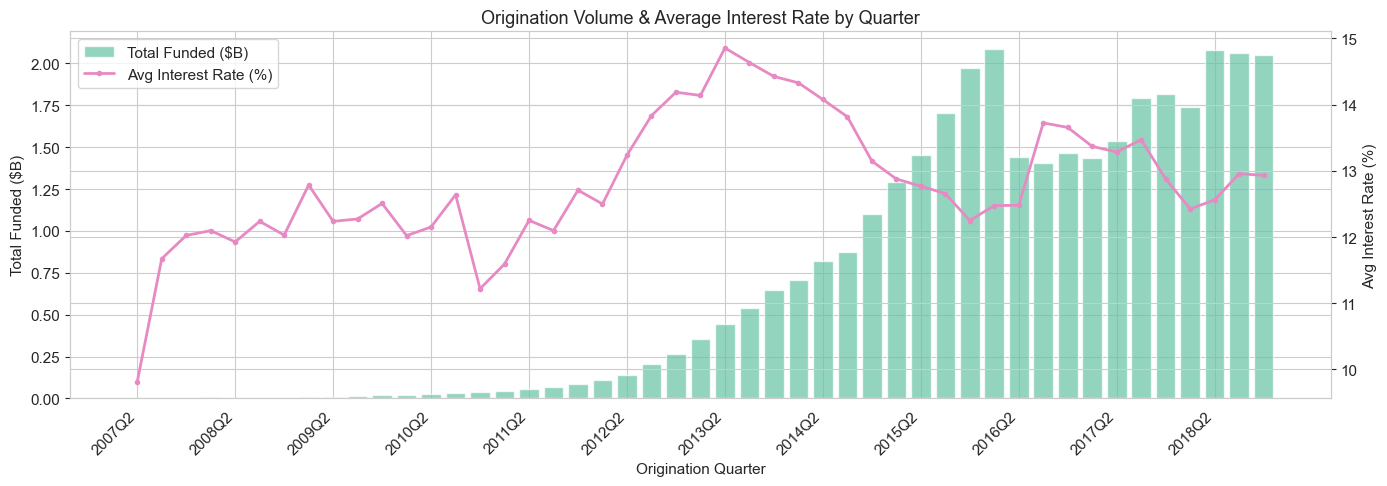

In [14]:
# ── Origination volume by quarter ──────────────────────────────
quarterly = (
    df.groupby("issue_quarter")
    .agg(
        loan_count=("id", "count"),
        total_funded=("funded_amnt", "sum"),
        avg_rate=("int_rate", "mean"),
    )
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

ax1.bar(range(len(quarterly)), quarterly["total_funded"] / 1e9,
        color=PALETTE[0], alpha=0.7, label="Total Funded ($B)")
ax2.plot(range(len(quarterly)), quarterly["avg_rate"] * 100,
         color=PALETTE[3], lw=2, marker="o", ms=3, label="Avg Interest Rate (%)")

# Labels every 4th quarter
tick_idx = list(range(0, len(quarterly), 4))
ax1.set_xticks(tick_idx)
ax1.set_xticklabels(quarterly["issue_quarter"].iloc[tick_idx], rotation=45, ha="right")
ax1.set_ylabel("Total Funded ($B)")
ax1.set_xlabel("Origination Quarter")
ax2.set_ylabel("Avg Interest Rate (%)")
ax1.set_title("Origination Volume & Average Interest Rate by Quarter")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


---
<a id="5-status"></a>
## 5. Loan Status Cleaning

### Key Observations
- This data is **not** a time series — each loan has a single snapshot (presumably the most recent).
- Each record contains data from up to three points: origination, the previous period, and the current period.
- Loans are broadly **active** (Current, In Grace Period, Late) or **inactive** (Fully Paid, Charged Off).
- The `loan_status` field is critical for understanding where each loan is in its lifecycle.

### Assumptions
- Each loan started as Current.
- Current loans have always been current (we can't see historical cashflows).
- Delinquent loans follow: Current → In Grace Period → Late (16–30) → Late (31–120) → Default → Charged Off


In [15]:
# ── Loan status distribution ───────────────────────────────────
status_summary = (
    df["loan_status"]
    .value_counts(dropna=False)
    .rename("count")
    .to_frame()
)
status_summary["percent"] = status_summary["count"] / status_summary["count"].sum() * 100
print(status_summary.to_string())


                                                       count    percent
loan_status                                                            
Fully Paid                                           1076751  47.629771
Current                                               878317  38.852100
Charged Off                                           268559  11.879630
Late (31-120 days)                                     21467   0.949587
In Grace Period                                         8436   0.373164
Late (16-30 days)                                       4349   0.192377
Does not meet the credit policy. Status:Fully Paid      1988   0.087939
Does not meet the credit policy. Status:Charged Off      761   0.033663
Default                                                   40   0.001769


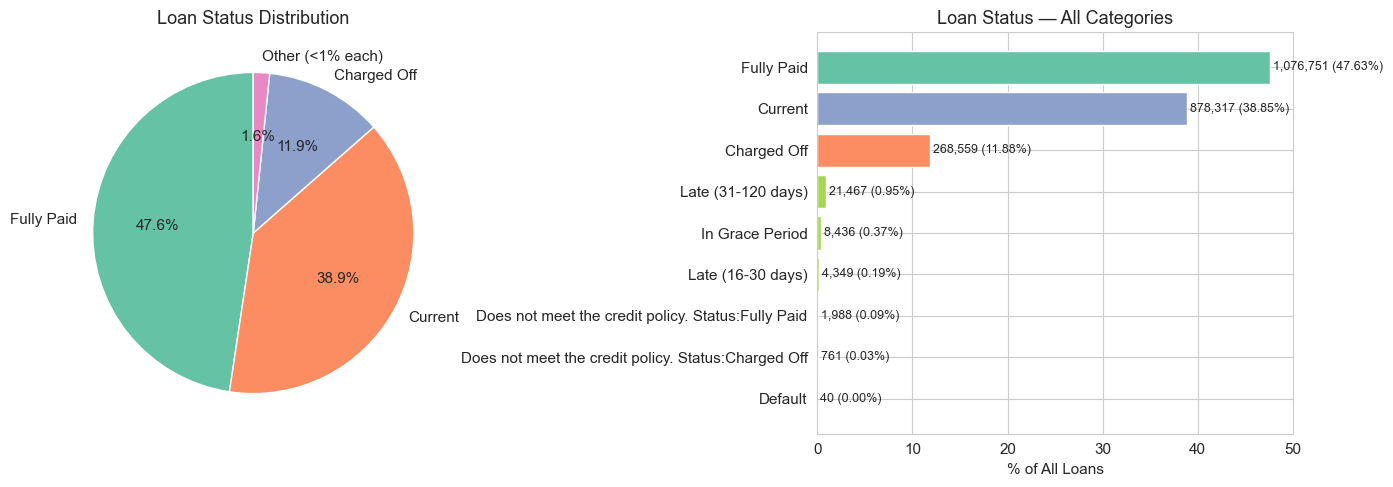

In [16]:
# ── Visualize loan status ──────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
statuses_main = status_summary[status_summary["percent"] > 1]
statuses_other = status_summary[status_summary["percent"] <= 1]
pie_data = pd.concat([
    statuses_main["count"],
    pd.Series({"Other (<1% each)": statuses_other["count"].sum()})
])
axes[0].pie(pie_data, labels=pie_data.index, autopct="%1.1f%%",
            colors=PALETTE[:len(pie_data)], startangle=90)
axes[0].set_title("Loan Status Distribution")

# Bar chart with all statuses
colors = [PALETTE[0] if "Fully Paid" in s else
          PALETTE[2] if "Current" in s else
          PALETTE[1] if "Charged" in s or "Default" in s else
          PALETTE[4]
          for s in status_summary.index]

axes[1].barh(status_summary.index[::-1], status_summary["percent"][::-1], color=colors[::-1])
axes[1].set_xlabel("% of All Loans")
axes[1].set_title("Loan Status — All Categories")
for i, (pct, cnt) in enumerate(zip(
    status_summary["percent"][::-1], status_summary["count"][::-1]
)):
    axes[1].text(pct + 0.3, i, f"{cnt:,.0f} ({pct:.2f}%)", va="center", fontsize=9)

plt.tight_layout()
plt.show()


### Drop "Does not meet the credit policy" loans

These are legacy loans that would no longer be approved by LC. They're already fully paid or charged off and represent <0.15% of the dataset.


In [17]:
credit_policy_mask = df["loan_status"].str.startswith("Does not meet")
n_policy = credit_policy_mask.sum()
print(f"Dropping {n_policy:,} 'Does not meet credit policy' loans ({n_policy/len(df)*100:.3f}%)")

df = df[~credit_policy_mask].copy()
print(f"Remaining: {df.shape[0]:,} loans")
print(f"\nUpdated status counts:")
print(df["loan_status"].value_counts().to_string())


Dropping 2,749 'Does not meet credit policy' loans (0.122%)
Remaining: 2,257,919 loans

Updated status counts:
loan_status
Fully Paid            1076751
Current                878317
Charged Off            268559
Late (31-120 days)      21467
In Grace Period          8436
Late (16-30 days)        4349
Default                    40


---
<a id="6-validate"></a>
## 6. All-Loans Validation

Critical fields that must be valid for every loan: `int_rate`, `issue_d`, `term`, `last_pymnt_d`.

### Findings
- 2,415 loans have no `last_pymnt_d` → dropped (no way to infer the payment date).
- No loans missing interest rate, issue date, or term.


In [18]:
# ── Check critical fields ──────────────────────────────────────
checks = {
    "last_pymnt_d before issue_d": (df["last_pymnt_d"] < df["issue_d"]).sum(),
    "Missing last_pymnt_d": df["last_pymnt_d"].isna().sum(),
    "Missing int_rate": df["int_rate"].isna().sum(),
    "Missing issue_d": df["issue_d"].isna().sum(),
    "Missing term": df["term"].isna().sum(),
}

for desc, count in checks.items():
    flag = " ⚠️" if count > 0 else " ✓"
    print(f"  {desc}: {count:,}{flag}")


  last_pymnt_d before issue_d: 0 ✓
  Missing last_pymnt_d: 2,415 ⚠️
  Missing int_rate: 0 ✓
  Missing issue_d: 0 ✓
  Missing term: 0 ✓


In [19]:
# ── Drop loans with no last payment date ───────────────────────
n_no_pymnt = df["last_pymnt_d"].isna().sum()
df = df[df["last_pymnt_d"].notna()].copy()
print(f"Dropped {n_no_pymnt:,} loans with no last payment date")
print(f"Remaining: {df.shape[0]:,} loans")


Dropped 2,415 loans with no last payment date
Remaining: 2,255,504 loans


In [20]:
# ── Verify non-charged-off loans have zero recoveries ──────────
non_co = df[df["loan_status"] != "Charged Off"]
print(f"Non-charged-off loans with recoveries > 0: {(non_co['recoveries'] > 0).sum()}")
print(f"Recovery stats for non-CO loans: min={non_co['recoveries'].min():.2f}, max={non_co['recoveries'].max():.2f}")


Non-charged-off loans with recoveries > 0: 0
Recovery stats for non-CO loans: min=0.00, max=0.00


---
<a id="7-amort"></a>
## 7. Amortization Schedule Calculations

Build expected amortization schedules from origination terms to:
1. Validate actual UPB vs. expected UPB (identify potential loan modifications)
2. Decompose last payment into scheduled principal, unscheduled principal (prepay), and interest
3. Compute SMM and CPR from the last observed payment


In [21]:
# ══════════════════════════════════════════════════════════════
# AMORTIZATION HELPER FUNCTIONS
# ══════════════════════════════════════════════════════════════

def calc_monthly_payment(principal, annual_rate, term_months):
    """Vectorized monthly payment: PMT = P × [r(1+r)^n] / [(1+r)^n − 1]"""
    r = annual_rate / 12.0
    zero = (r == 0)
    num = r * (1 + r) ** term_months
    den = (1 + r) ** term_months - 1
    with np.errstate(divide="ignore", invalid="ignore"):
        pmt = principal * (num / den)
    pmt[zero] = principal[zero] / term_months[zero]
    return pmt


def calc_balance(principal, annual_rate, monthly_payment, payments_made):
    """Iterative remaining-balance calculation after N payments."""
    r = annual_rate / 12.0
    bal = principal.copy().astype(np.float64)
    tot_prin = np.zeros_like(principal, dtype=np.float64)
    tot_int = np.zeros_like(principal, dtype=np.float64)

    max_n = int(np.max(payments_made)) if len(payments_made) > 0 else 0
    for i in range(1, max_n + 1):
        active = payments_made >= i
        if not active.any():
            break
        interest = bal * r
        prin_pmt = np.minimum(monthly_payment - interest, bal)
        bal[active] -= prin_pmt[active]
        tot_prin[active] += prin_pmt[active]
        tot_int[active] += interest[active]

    return np.maximum(bal, 0.0), tot_prin, tot_int


def calc_payments_made(start, end):
    """Months elapsed between two date Series."""
    return ((end.dt.year - start.dt.year) * 12 + (end.dt.month - start.dt.month)).values.astype(float)


In [22]:
def build_amort_schedule(df, verbose=True):
    """
    Enriches the DataFrame with amortization-derived columns:
      - orig_exp_* : expected values from original loan terms
      - last_pmt_* : decomposition of the last observed payment
      - next_pmt_* : projection for the next scheduled payment
      - updated_remaining_term, updated_maturity_date
    """
    out = df.copy()
    principal = out["funded_amnt"].values.astype(np.float64)
    rate      = out["int_rate"].values.astype(np.float64)
    term      = out["term_months"].values.astype(np.float64)
    r         = rate / 12.0

    # ── Part 1: Original schedule ──────────────────────────────
    pmt = calc_monthly_payment(principal, rate, term)
    n_paid = calc_payments_made(out["issue_d"], out["last_pymnt_d"])
    n_paid = np.clip(n_paid, 0, term)

    exp_bal, exp_prin, exp_int = calc_balance(principal, rate, pmt, n_paid)

    out["orig_exp_monthly_payment"]  = np.round(pmt, 2)
    out["orig_exp_payments_made"]    = n_paid.astype(int)
    out["orig_exp_balance"]          = np.round(exp_bal, 2)
    out["orig_exp_total_principal"]  = np.round(exp_prin, 2)
    out["orig_exp_total_interest"]   = np.round(exp_int, 2)

    # Balance & installment diffs
    if "out_prncp" in out.columns:
        out["orig_exp_balance_diff"] = np.round(out["out_prncp"] - exp_bal, 2)
    if "installment" in out.columns:
        out["orig_exp_installment_diff"] = np.round(out["installment"] - pmt, 2)

    # ── Part 2: Last-payment decomposition ─────────────────────
    has_pmt = n_paid > 0
    pre_bal, _, _ = calc_balance(principal, rate, pmt, np.maximum(n_paid - 1, 0))
    exp_interest  = pre_bal * r
    exp_principal = np.minimum(pmt - exp_interest, pre_bal)

    out["orig_exp_monthly_principal"] = np.round(np.where(has_pmt, exp_principal, 0), 2)
    out["orig_exp_monthly_interest"]  = np.round(np.where(has_pmt, pmt - exp_principal, 0), 2)

    if all(c in out.columns for c in ["out_prncp", "last_pymnt_amnt", "installment"]):
        upb       = out["out_prncp"].values
        last_pmt  = out["last_pymnt_amnt"].values
        inst      = out["installment"].values
        has_last  = (last_pmt > 0) & has_pmt

        with np.errstate(divide="ignore", invalid="ignore"):
            beg_bal = (upb + last_pmt) / (1 + r)

        lp_interest = beg_bal * r
        lp_actual_prin = last_pmt - lp_interest
        lp_sched_prin  = inst - lp_interest
        lp_unsched     = lp_actual_prin - lp_sched_prin

        with np.errstate(divide="ignore", invalid="ignore"):
            denom = beg_bal - lp_sched_prin
            smm = np.where((denom > 0) & has_last, lp_unsched / denom, 0)
        cpr = np.where(has_last, 1 - (1 - smm) ** 12, 0)

        out["last_pmt_beginning_balance"]     = np.round(beg_bal, 2)
        out["last_pmt_interest"]              = np.round(lp_interest, 2)
        out["last_pmt_actual_principal"]       = np.round(lp_actual_prin, 2)
        out["last_pmt_scheduled_principal"]    = np.round(lp_sched_prin, 2)
        out["last_pmt_unscheduled_principal"]  = np.round(lp_unsched, 2)
        out["last_pmt_smm"]                   = np.round(smm, 6)
        out["last_pmt_cpr"]                   = np.round(cpr, 6)

    # ── Part 3: Next-payment projection ────────────────────────
    if all(c in out.columns for c in ["out_prncp", "installment"]):
        cur_bal = out["out_prncp"].values
        act_pmt = out["installment"].values
        has_bal = cur_bal > 0

        nxt_int  = cur_bal * r
        nxt_prin = np.minimum(act_pmt - nxt_int, cur_bal)
        nxt_prin[~has_bal] = 0
        nxt_int[~has_bal]  = 0

        out["next_pmt_principal"] = np.round(nxt_prin, 2)
        out["next_pmt_interest"]  = np.round(nxt_int, 2)

        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = np.minimum((r * cur_bal) / act_pmt, 0.9999)
            rem_term = -np.log(1 - ratio) / np.log(1 + r)
            zero_r = (r == 0)
            rem_term[zero_r] = cur_bal[zero_r] / act_pmt[zero_r]
            rem_term = np.ceil(rem_term)
        rem_term[~has_bal] = 0
        rem_term = np.minimum(rem_term, 600).astype(int)

        out["updated_remaining_term"] = rem_term
        out["updated_maturity_date"] = (
            out["last_pymnt_d"].dt.to_period("M") + out["updated_remaining_term"]
        ).dt.to_timestamp()

    if verbose:
        print(f"Amortization schedule built for {len(out):,} loans")
        print(f"  Mean expected payment: ${out['orig_exp_monthly_payment'].mean():.2f}")
        print(f"  Total expected balance: ${out['orig_exp_balance'].sum():,.0f}")
    return out

df = build_amort_schedule(df)


Amortization schedule built for 2,255,504 loans
  Mean expected payment: $445.97
  Total expected balance: $19,977,090,910


### Visualization: Expected vs. Actual UPB

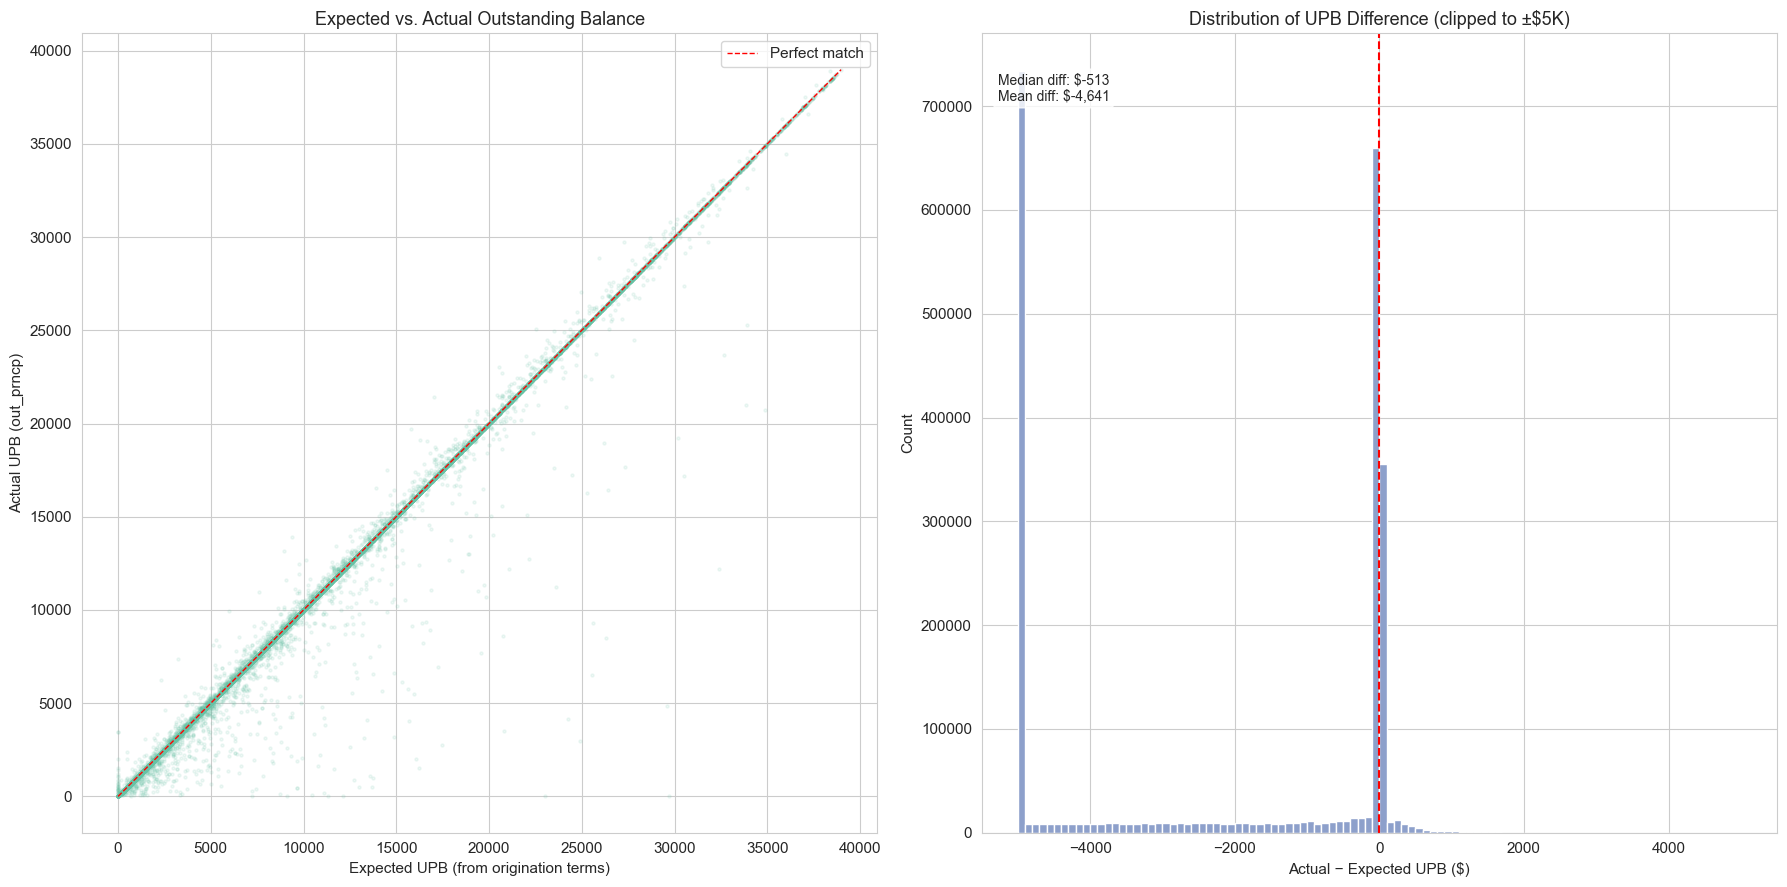

In [24]:
# ── Expected vs Actual UPB scatter ─────────────────────────────
sample = df[df["out_prncp"] > 0].sample(min(20_000, (df["out_prncp"] > 0).sum()), random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Scatter: expected vs actual balance
axes[0].scatter(sample["orig_exp_balance"], sample["out_prncp"],
                alpha=0.1, s=5, color=PALETTE[0])
max_val = max(sample["orig_exp_balance"].max(), sample["out_prncp"].max())
axes[0].plot([0, max_val], [0, max_val], "r--", lw=1, label="Perfect match")
axes[0].set_xlabel("Expected UPB (from origination terms)")
axes[0].set_ylabel("Actual UPB (out_prncp)")
axes[0].set_title("Expected vs. Actual Outstanding Balance")
axes[0].legend()

# Histogram of balance difference
diff = df["orig_exp_balance_diff"].dropna()
diff_clipped = diff.clip(-5000, 5000)
axes[1].hist(diff_clipped, bins=100, color=PALETTE[2], edgecolor="white")
axes[1].axvline(0, color="red", ls="--", lw=1.5)
axes[1].set_xlabel("Actual − Expected UPB ($)")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of UPB Difference (clipped to ±$5K)")
axes[1].annotate(f"Median diff: ${diff.median():,.0f}\nMean diff: ${diff.mean():,.0f}",
                 xy=(0.02, 0.95), xycoords="axes fraction", va="top",
                 fontsize=10, bbox=dict(boxstyle="round", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()


---
<a id="8-current"></a>
## 8. Current Loans Cleaning

**Key characteristics of Current loans:**
- Should have made payments recently
- Should have outstanding UPB > 0

### UPB Check
4,537 loans labeled "Current" have `out_prncp == 0` (funded amount equals total principal received). These are actually fully paid → relabel them.


In [25]:
# ── Reclassify zero-UPB Current loans as Fully Paid ────────────
mask_current_paid = (df["loan_status"] == "Current") & (df["out_prncp"] == 0)
n_reclass = mask_current_paid.sum()
print(f"Current loans with zero UPB: {n_reclass:,} → relabeling to 'Fully Paid'")
df.loc[mask_current_paid, "loan_status"] = "Fully Paid"


Current loans with zero UPB: 4,537 → relabeling to 'Fully Paid'


### Last Payment Date Check

- 52K current loans last paid in February (data as-of March 2019) — likely haven't been updated yet. Keep them.
- 6 loans with even earlier last payment dates — too few to matter, drop them.


In [26]:
current = df[df["loan_status"] == "Current"]
print("Last payment date distribution for Current loans:")
print(current["last_pymnt_d"].value_counts().head(10))


Last payment date distribution for Current loans:
last_pymnt_d
2019-03-01    821603
2019-02-01     52171
2018-07-01         2
2019-01-01         2
2018-10-01         1
2018-02-01         1
Name: count, dtype: int64


In [27]:
# ── Drop current loans with stale last payment dates ──────────
mask_stale = (
    (df["loan_status"] == "Current")
    & (df["last_pymnt_d"] != "2019-03-01")
    & (df["last_pymnt_d"] != "2019-02-01")
)
n_stale = mask_stale.sum()
print(f"Dropping {n_stale} current loans with stale payment dates")
df = df[~mask_stale].copy()


Dropping 6 current loans with stale payment dates


### Late Fee Flag

LC charges a late fee of $15 or 5% of the payment (whichever is greater). If a Current or Fully Paid loan has accumulated late fees, it was delinquent at some point — flag it.


In [28]:
# ── Clean late fee amounts and create flag ─────────────────────
# Tiny negative late fees → 0
df.loc[df["total_rec_late_fee"] < 0, "total_rec_late_fee"] = 0

# Sub-$15 amounts are noise → 0
mask_tiny_fee = (df["loan_status"] == "Current") & (df["total_rec_late_fee"] > 0) & (df["total_rec_late_fee"] < 15)
df.loc[mask_tiny_fee, "total_rec_late_fee"] = 0.0

# Flag current loans that were previously late
mask_was_late = (df["loan_status"] == "Current") & (df["total_rec_late_fee"] > 0)
df["current_late_fee_flag"] = np.where(mask_was_late, 1, 0)
print(f"Current loans with late-fee history: {df['current_late_fee_flag'].sum():,}")


Current loans with late-fee history: 18,419


---
<a id="9-late"></a>
## 9. Late Loans Cleaning

**Key characteristics:**
- Should have UPB outstanding (most of them do)
- In Grace Period → Late (16–30) → Late (31–120) → Default → Charged Off

Some late loans have `out_prncp == 0` — they actually prepaid (often with a large last payment). Create transition flags and relabel where appropriate.


In [29]:
# ── Inspect late-loan subsets ──────────────────────────────────
for status in ["In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]:
    subset = df[df["loan_status"] == status]
    zero_upb = (subset["out_prncp"] == 0).sum()
    print(f"{status}: {len(subset):,} loans, {zero_upb} with zero UPB")


In Grace Period: 8,436 loans, 107 with zero UPB
Late (16-30 days): 4,349 loans, 35 with zero UPB
Late (31-120 days): 21,365 loans, 26 with zero UPB


In [30]:
# ── Create transition flags for late loans that fully paid ─────
df["grace_to_paid_flag"] = np.where(
    (df["loan_status"] == "In Grace Period") & (df["out_prncp"] == 0), 1, 0
)
df["late1_to_paid_flag"] = np.where(
    (df["loan_status"] == "Late (16-30 days)") & (df["out_prncp"] == 0), 1, 0
)
df["late2_to_paid_flag"] = np.where(
    (df["loan_status"] == "Late (31-120 days)") & (df["out_prncp"] == 0), 1, 0
)

print("Transition flags (late → paid):")
print(f"  Grace Period → Paid: {df['grace_to_paid_flag'].sum()}")
print(f"  Late (16-30)  → Paid: {df['late1_to_paid_flag'].sum()}")
print(f"  Late (31-120) → Paid: {df['late2_to_paid_flag'].sum()}")


Transition flags (late → paid):
  Grace Period → Paid: 107
  Late (16-30)  → Paid: 35
  Late (31-120) → Paid: 26


### Visualization: Loan Status Transition Summary

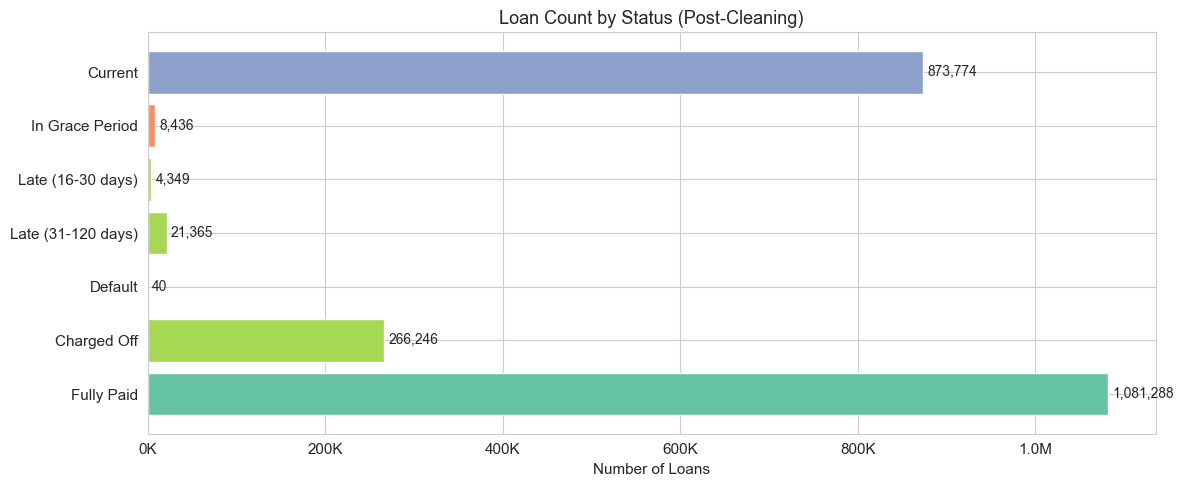

In [31]:
# ── Delinquency pipeline visualization ─────────────────────────
status_order = ["Current", "In Grace Period", "Late (16-30 days)",
                "Late (31-120 days)", "Default", "Charged Off", "Fully Paid"]
status_counts = df["loan_status"].value_counts()
ordered = [status_counts.get(s, 0) for s in status_order]

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.barh(status_order[::-1], [o for o in ordered[::-1]],
               color=[PALETTE[2], PALETTE[1], PALETTE[4], PALETTE[4],
                      PALETTE[4], PALETTE[4], PALETTE[0]][::-1])
for bar, count in zip(bars, ordered[::-1]):
    ax.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2,
            f"{count:,}", va="center", fontsize=10)
ax.set_xlabel("Number of Loans")
ax.set_title("Loan Count by Status (Post-Cleaning)")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K"))
plt.tight_layout()
plt.show()


---
<a id="10-default"></a>
## 10. Default & Charged-Off Loans Cleaning

**Default** (40 loans): still have outstanding principal, no recoveries yet.
**Charged Off** (~268K): principal written off; may have partial recoveries.

### Loss Given Default (LGD)

`UPB Lost = funded_amnt − total_rec_prncp − recoveries`


In [32]:
# ── Inspect defaults and charge-offs ───────────────────────────
default = df[df["loan_status"] == "Default"]
charged = df[df["loan_status"] == "Charged Off"]

print(f"Default loans: {len(default):,}")
print(f"  Mean outstanding UPB: ${default['out_prncp'].mean():,.0f}")
print(f"  Mean recoveries: ${default['recoveries'].mean():,.2f}")

print(f"\nCharged-Off loans: {len(charged):,}")
print(f"  Mean outstanding UPB: ${charged['out_prncp'].mean():,.0f}  (should be ~0)")
print(f"  Mean recoveries: ${charged['recoveries'].mean():,.2f}")
print(f"  Loans with any recovery: {(charged['recoveries'] > 0).sum():,} ({(charged['recoveries'] > 0).mean()*100:.1f}%)")


Default loans: 40
  Mean outstanding UPB: $9,573
  Mean recoveries: $0.00

Charged-Off loans: 266,246
  Mean outstanding UPB: $0  (should be ~0)
  Mean recoveries: $1,207.52
  Loans with any recovery: 183,215 (68.8%)


In [33]:
# ── Compute UPB lost (negative = loss) ─────────────────────────
mask_co = df["loan_status"] == "Charged Off"
df["upb_lost"] = np.where(
    mask_co,
    -(df["funded_amnt"] - df["total_rec_prncp"] - df["recoveries"]),
    0
)
co_losses = df.loc[mask_co, "upb_lost"]
print(f"Charged-Off Loss Summary:")
print(f"  Total principal lost: ${-co_losses.sum():,.0f}")
print(f"  Mean loss per loan: ${-co_losses.mean():,.0f}")
print(f"  Loss severity: {(-co_losses.sum() / df.loc[mask_co, 'funded_amnt'].sum())*100:.1f}%")


Charged-Off Loss Summary:
  Total principal lost: $2,643,402,193
  Mean loss per loan: $9,928
  Loss severity: 63.8%


### Visualization: Loss & Recovery Analysis

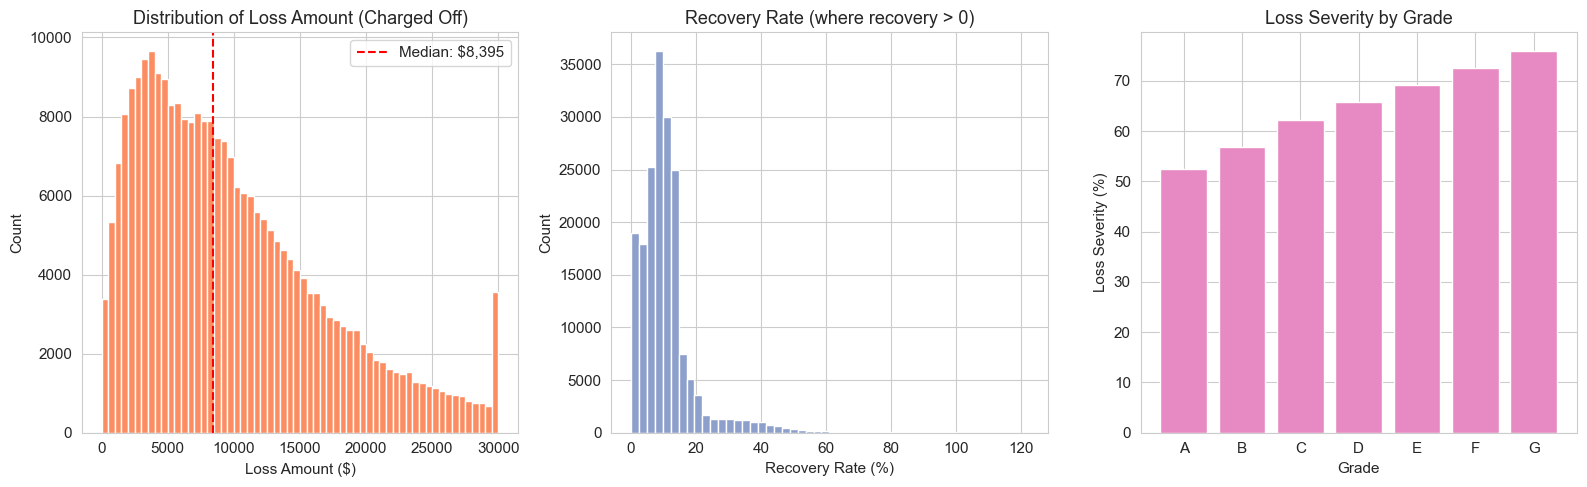

In [34]:
# ── Loss severity distribution ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Loss amount distribution
loss_amounts = -df.loc[mask_co, "upb_lost"]
axes[0].hist(loss_amounts.clip(0, 30000), bins=60, color=PALETTE[1], edgecolor="white")
axes[0].set_xlabel("Loss Amount ($)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Loss Amount (Charged Off)")
axes[0].axvline(loss_amounts.median(), color="red", ls="--", label=f"Median: ${loss_amounts.median():,.0f}")
axes[0].legend()

# Recovery rate
co = df[mask_co].copy()
co["recovery_rate"] = co["recoveries"] / co["funded_amnt"]
axes[1].hist(co.loc[co["recoveries"] > 0, "recovery_rate"] * 100,
             bins=50, color=PALETTE[2], edgecolor="white")
axes[1].set_xlabel("Recovery Rate (%)")
axes[1].set_ylabel("Count")
axes[1].set_title("Recovery Rate (where recovery > 0)")

# Loss by grade
loss_by_grade = (
    df[mask_co]
    .groupby("grade")
    .agg(
        total_funded=("funded_amnt", "sum"),
        total_loss=("upb_lost", lambda x: -x.sum()),
    )
)
loss_by_grade["severity"] = loss_by_grade["total_loss"] / loss_by_grade["total_funded"] * 100
loss_by_grade = loss_by_grade.sort_index()
axes[2].bar(loss_by_grade.index, loss_by_grade["severity"], color=PALETTE[3])
axes[2].set_xlabel("Grade")
axes[2].set_ylabel("Loss Severity (%)")
axes[2].set_title("Loss Severity by Grade")

plt.tight_layout()
plt.show()


---
<a id="11-final"></a>
## 11. Final Column Cleaning

Consolidate joint/individual metrics and handle remaining edge cases.


In [35]:
# ── Joint application flag & consolidated DTI/income ───────────
df["joint_app_flag"] = np.where(df["application_type"] != "Individual", 1, 0)

df["dti_clean"] = np.where(
    df["joint_app_flag"] == 0,
    df["dti"],
    df["dti_joint"]
)
df["annual_inc_clean"] = np.where(
    df["joint_app_flag"] == 0,
    df["annual_inc"],
    df["annual_inc_joint"]
)
print(f"Joint applications: {df['joint_app_flag'].sum():,} ({df['joint_app_flag'].mean()*100:.1f}%)")


Joint applications: 120,581 (5.3%)


In [36]:
# ── FICO midpoint columns ──────────────────────────────────────
df["original_fico"] = (df["fico_range_high"] + df["fico_range_low"]) / 2
df["latest_fico"]   = (df["last_fico_range_high"] + df["last_fico_range_low"]) / 2

print(f"Original FICO — mean: {df['original_fico'].mean():.0f}, "
      f"median: {df['original_fico'].median():.0f}")
print(f"Latest FICO   — mean: {df['latest_fico'].mean():.0f}, "
      f"median: {df['latest_fico'].median():.0f}")


Original FICO — mean: 701, median: 692
Latest FICO   — mean: 682, median: 697


In [37]:
# ── Fix negative/missing DTI ────────────────────────────────────
df.loc[df["dti_clean"] < 0, "dti_clean"] = 0

n_dti_na = df["dti_clean"].isna().sum()
print(f"Dropping {n_dti_na} loans with missing DTI")
df = df[df["dti_clean"].notna()].copy()

# ── Fix negative late fees ─────────────────────────────────────
df["total_rec_late_fee"] = np.round(df["total_rec_late_fee"], 2)
df.loc[df["total_rec_late_fee"] < 0, "total_rec_late_fee"] = 0

# ── Combined late-flag for Fully Paid & Current loans ──────────
mask_late_flag = (
    df["loan_status"].isin(["Fully Paid", "Current"])
    & (df["total_rec_late_fee"] >= 15)
)
df["curr_paid_late1_flag"] = np.where(mask_late_flag, 1, 0)
print(f"Current/Paid loans with late-fee history: {df['curr_paid_late1_flag'].sum():,}")


Dropping 4 loans with missing DTI
Current/Paid loans with late-fee history: 42,369


In [38]:
# ── Final shape ────────────────────────────────────────────────
print(f"\n{'='*60}")
print(f"CLEAN DATASET: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"{'='*60}")
print(f"\nLoan status breakdown:")
print(df["loan_status"].value_counts().to_string())



CLEAN DATASET: 2,255,494 rows × 164 columns

Loan status breakdown:
loan_status
Fully Paid            1081285
Current                873773
Charged Off            266246
Late (31-120 days)      21365
In Grace Period          8436
Late (16-30 days)        4349
Default                    40


---
<a id="12-metrics"></a>
## 12. Exploratory Visualizations & Credit Metrics

Now that the dataset is clean, let's explore key characteristics and compute portfolio-level credit metrics.


### 12a. Pool Stratifications

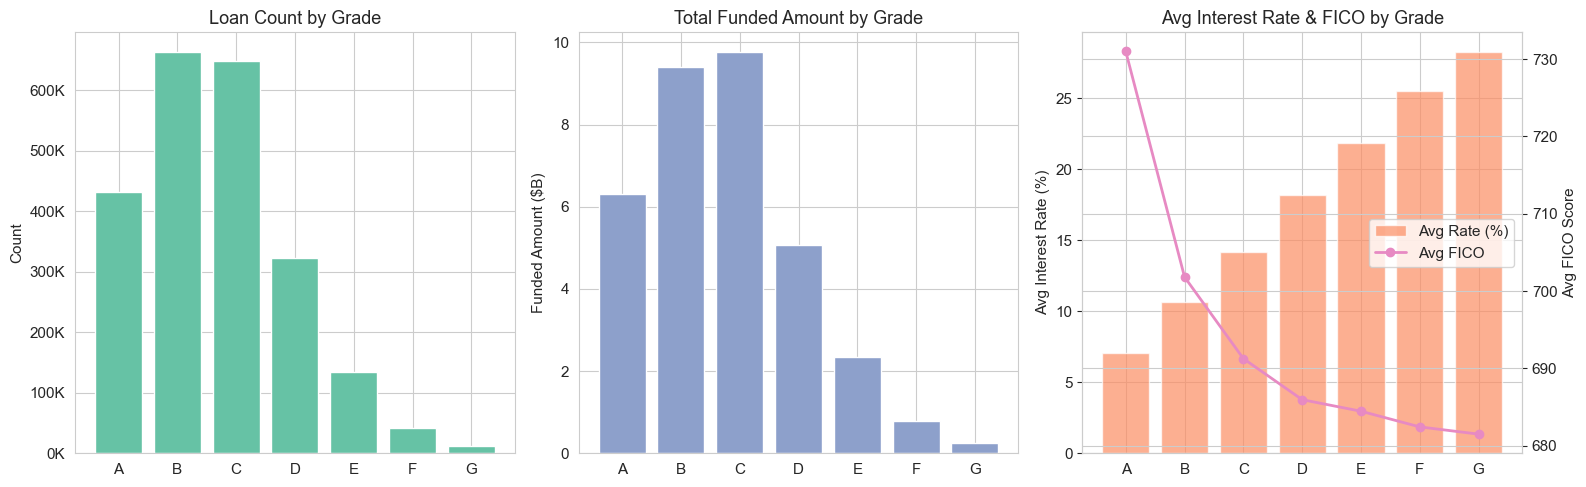

In [39]:
# ── Grade distribution (by count and UPB) ──────────────────────
grade_stats = (
    df.groupby("grade")
    .agg(
        count=("id", "count"),
        total_upb=("funded_amnt", "sum"),
        avg_rate=("int_rate", "mean"),
        avg_fico=("original_fico", "mean"),
    )
    .sort_index()
)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Count by grade
axes[0].bar(grade_stats.index, grade_stats["count"], color=PALETTE[0])
axes[0].set_title("Loan Count by Grade")
axes[0].set_ylabel("Count")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e3:.0f}K"))

# UPB by grade
axes[1].bar(grade_stats.index, grade_stats["total_upb"] / 1e9, color=PALETTE[2])
axes[1].set_title("Total Funded Amount by Grade")
axes[1].set_ylabel("Funded Amount ($B)")

# Avg rate and FICO by grade
ax2 = axes[2].twinx()
axes[2].bar(grade_stats.index, grade_stats["avg_rate"] * 100,
            color=PALETTE[1], alpha=0.7, label="Avg Rate (%)")
ax2.plot(grade_stats.index, grade_stats["avg_fico"],
         color=PALETTE[3], marker="o", lw=2, label="Avg FICO")
axes[2].set_title("Avg Interest Rate & FICO by Grade")
axes[2].set_ylabel("Avg Interest Rate (%)")
ax2.set_ylabel("Avg FICO Score")
lines1, labels1 = axes[2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[2].legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.tight_layout()
plt.show()


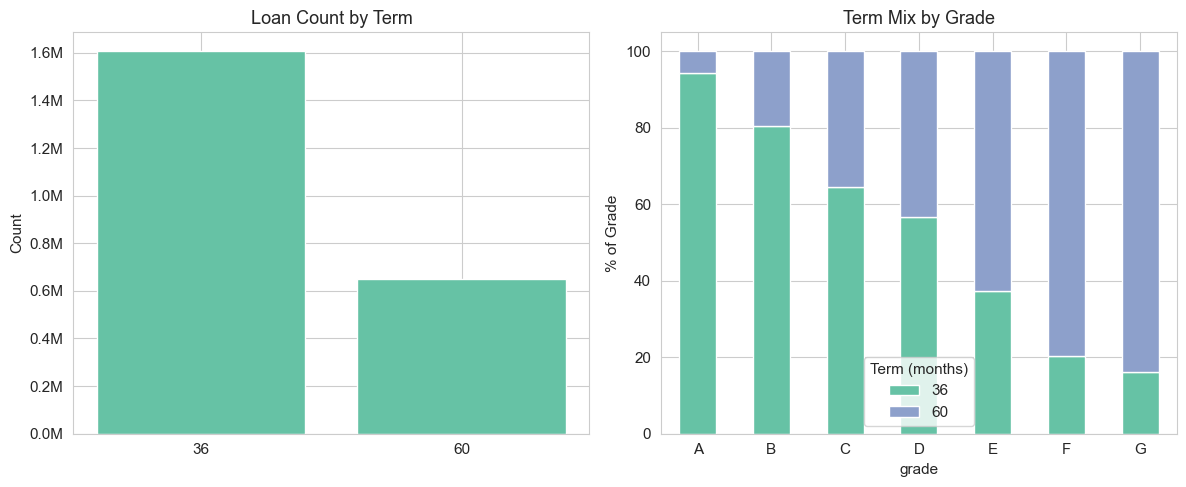

In [40]:
# ── Term distribution ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

term_counts = df["term_months"].value_counts().sort_index()
axes[0].bar(term_counts.index.astype(str), term_counts.values, color=PALETTE[0])
axes[0].set_title("Loan Count by Term")
axes[0].set_ylabel("Count")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))

# Term by grade (stacked)
term_grade = pd.crosstab(df["grade"], df["term_months"], normalize="index") * 100
term_grade.plot(kind="bar", stacked=True, ax=axes[1], color=[PALETTE[0], PALETTE[2]])
axes[1].set_title("Term Mix by Grade")
axes[1].set_ylabel("% of Grade")
axes[1].legend(title="Term (months)")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()


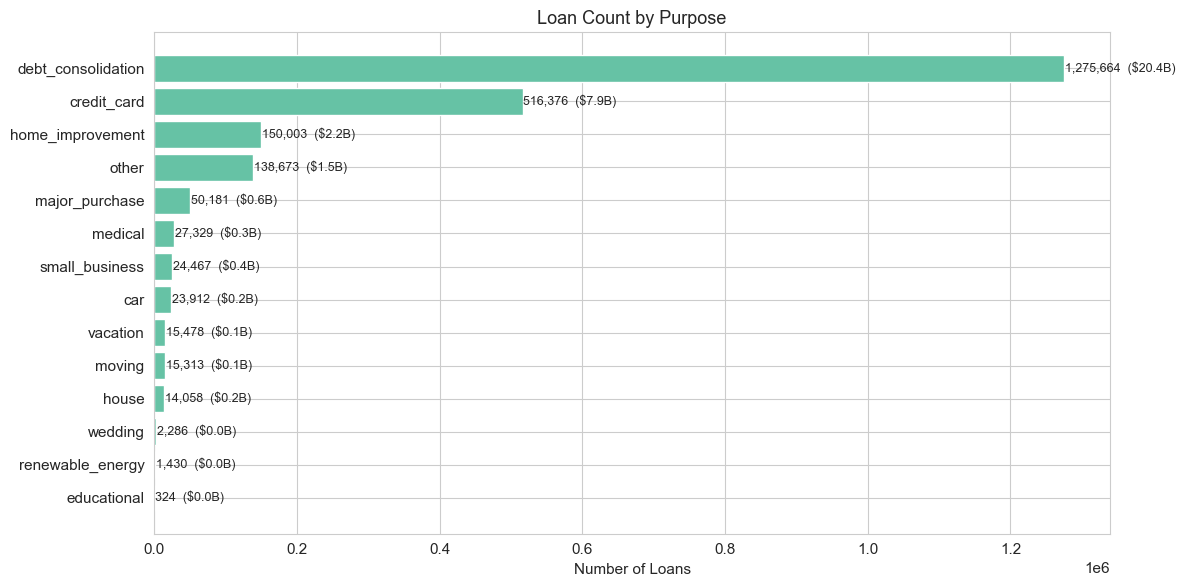

In [41]:
# ── Purpose distribution ───────────────────────────────────────
purpose_stats = (
    df.groupby("purpose")
    .agg(count=("id", "count"), total_upb=("funded_amnt", "sum"))
    .sort_values("count", ascending=True)
)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(purpose_stats.index, purpose_stats["count"], color=PALETTE[0])
ax.set_xlabel("Number of Loans")
ax.set_title("Loan Count by Purpose")
for i, (count, upb) in enumerate(zip(purpose_stats["count"], purpose_stats["total_upb"])):
    ax.text(count + 1000, i, f"{count:,}  (${upb/1e9:.1f}B)", va="center", fontsize=9)
plt.tight_layout()
plt.show()


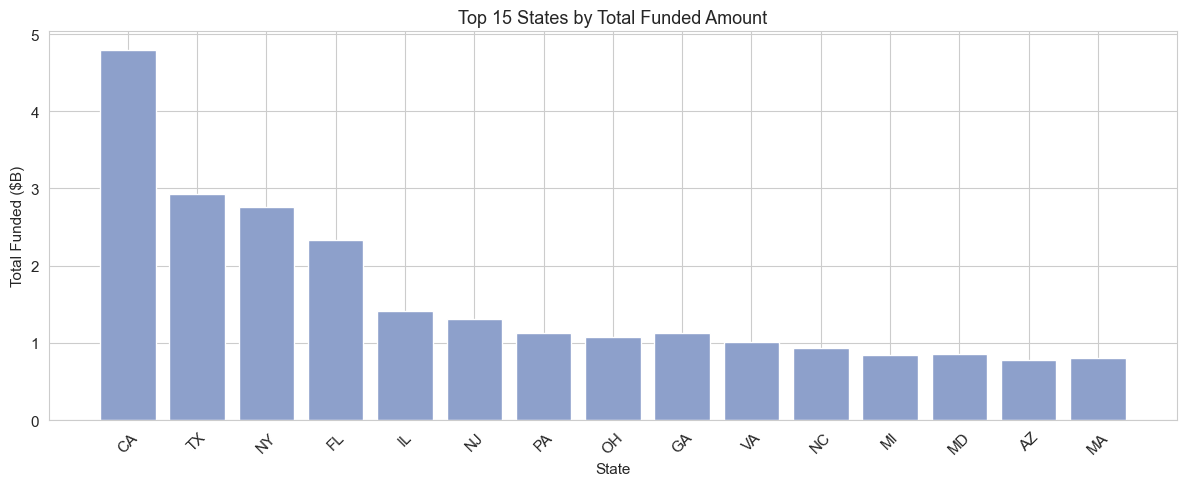

In [42]:
# ── Geographic distribution (top 15 states) ────────────────────
state_stats = (
    df.groupby("addr_state")
    .agg(count=("id", "count"), total_upb=("funded_amnt", "sum"))
    .sort_values("count", ascending=False)
    .head(15)
)

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(state_stats.index, state_stats["total_upb"] / 1e9, color=PALETTE[2])
ax.set_ylabel("Total Funded ($B)")
ax.set_xlabel("State")
ax.set_title("Top 15 States by Total Funded Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 12b. Credit Metrics

Point-in-time metrics (weighted by current UPB for active loans):
- **WAC** (Weighted Average Coupon)
- **WAM** (Weighted Average Maturity)
- **WALA** (Weighted Average Loan Age)
- **FICO** and **DTI** distributions


In [43]:
# ── WAC, WAM, WALA for active loans ────────────────────────────
active = df[df["loan_status"].isin(["Current", "In Grace Period",
                                     "Late (16-30 days)", "Late (31-120 days)"])].copy()
active_upb = active["out_prncp"]
total_upb = active_upb.sum()

wac = np.average(active["int_rate"], weights=active_upb) * 100
wam = np.average(active["updated_remaining_term"], weights=active_upb)
wala = np.average(active["orig_exp_payments_made"], weights=active_upb)
avg_fico = np.average(active["original_fico"], weights=active_upb)
avg_dti = np.average(active["dti_clean"].fillna(0), weights=active_upb)

print(f"Active Pool Credit Metrics (UPB-weighted)")
print(f"{'='*50}")
print(f"  Total UPB:          ${total_upb:,.0f}")
print(f"  Loan Count:         {len(active):,}")
print(f"  WAC:                {wac:.2f}%")
print(f"  WAM:                {wam:.1f} months")
print(f"  WALA:               {wala:.1f} months")
print(f"  Avg Original FICO:  {avg_fico:.0f}")
print(f"  Avg DTI:            {avg_dti:.1f}")


Active Pool Credit Metrics (UPB-weighted)
  Total UPB:          $9,508,492,787
  Loan Count:         907,923
  WAC:                13.25%
  WAM:                34.5 months
  WALA:               13.9 months
  Avg Original FICO:  708
  Avg DTI:            18.5


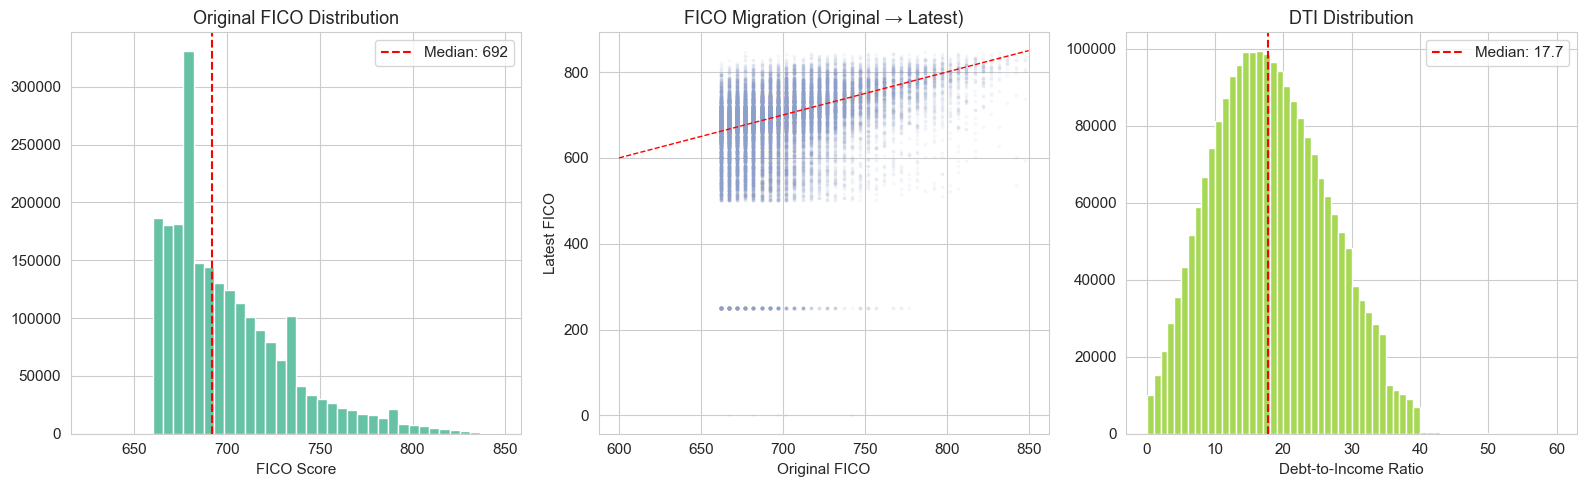

In [44]:
# ── FICO and DTI distributions ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original FICO
axes[0].hist(df["original_fico"].dropna(), bins=40, color=PALETTE[0], edgecolor="white")
axes[0].axvline(df["original_fico"].median(), color="red", ls="--",
                label=f"Median: {df['original_fico'].median():.0f}")
axes[0].set_xlabel("FICO Score")
axes[0].set_title("Original FICO Distribution")
axes[0].legend()

# FICO migration (original vs latest)
has_both = df[["original_fico", "latest_fico"]].dropna()
sample_fico = has_both.sample(min(30_000, len(has_both)), random_state=42)
axes[1].scatter(sample_fico["original_fico"], sample_fico["latest_fico"],
                alpha=0.05, s=3, color=PALETTE[2])
axes[1].plot([600, 850], [600, 850], "r--", lw=1)
axes[1].set_xlabel("Original FICO")
axes[1].set_ylabel("Latest FICO")
axes[1].set_title("FICO Migration (Original → Latest)")

# DTI distribution
dti_clean = df["dti_clean"].dropna()
axes[2].hist(dti_clean.clip(0, 60), bins=60, color=PALETTE[4], edgecolor="white")
axes[2].axvline(dti_clean.median(), color="red", ls="--",
                label=f"Median: {dti_clean.median():.1f}")
axes[2].set_xlabel("Debt-to-Income Ratio")
axes[2].set_title("DTI Distribution")
axes[2].legend()

plt.tight_layout()
plt.show()


### 12c. Performance Metrics by Vintage

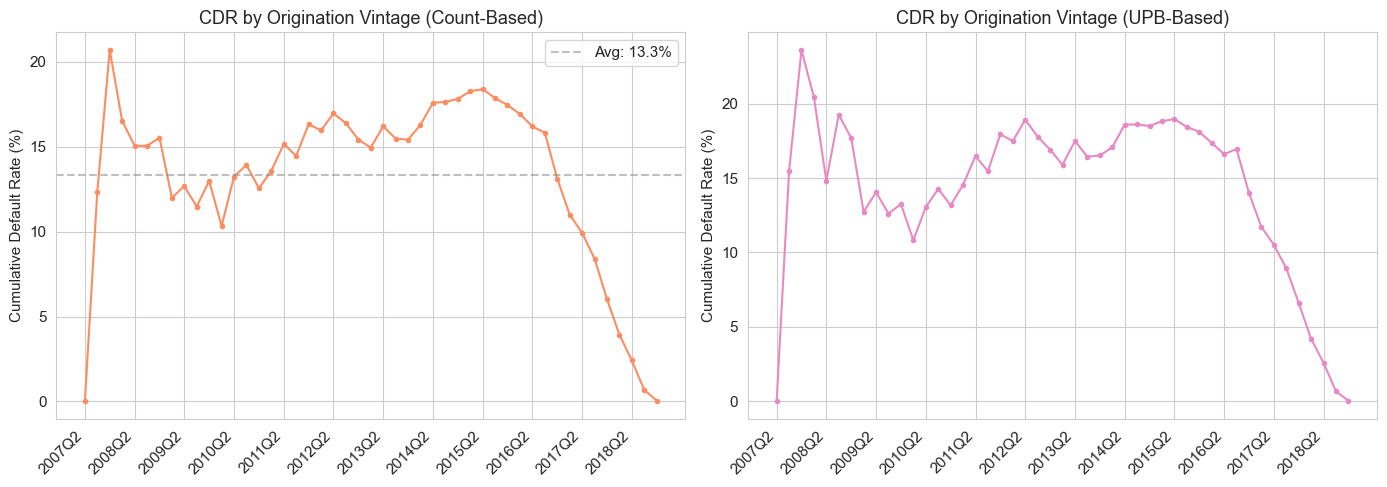

In [45]:
# ── CDR by vintage quarter ─────────────────────────────────────
default_statuses = {"Charged Off", "Default"}
df["is_default"] = df["loan_status"].isin(default_statuses)

cdr_by_q = (
    df.groupby("issue_quarter")
    .agg(
        loan_count=("id", "count"),
        default_count=("is_default", "sum"),
        total_funded=("funded_amnt", "sum"),
        default_funded=("funded_amnt", lambda x: x[df.loc[x.index, "is_default"]].sum()),
    )
)
cdr_by_q["cdr_count"] = cdr_by_q["default_count"] / cdr_by_q["loan_count"] * 100
cdr_by_q["cdr_upb"] = cdr_by_q["default_funded"] / cdr_by_q["total_funded"] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CDR by count
axes[0].plot(range(len(cdr_by_q)), cdr_by_q["cdr_count"],
             color=PALETTE[1], marker="o", ms=3, lw=1.5)
tick_idx = list(range(0, len(cdr_by_q), 4))
axes[0].set_xticks(tick_idx)
axes[0].set_xticklabels(cdr_by_q.index[tick_idx], rotation=45, ha="right")
axes[0].set_ylabel("Cumulative Default Rate (%)")
axes[0].set_title("CDR by Origination Vintage (Count-Based)")
axes[0].axhline(cdr_by_q["cdr_count"].mean(), color="grey", ls="--", alpha=0.5,
                label=f"Avg: {cdr_by_q['cdr_count'].mean():.1f}%")
axes[0].legend()

# CDR by UPB
axes[1].plot(range(len(cdr_by_q)), cdr_by_q["cdr_upb"],
             color=PALETTE[3], marker="o", ms=3, lw=1.5)
axes[1].set_xticks(tick_idx)
axes[1].set_xticklabels(cdr_by_q.index[tick_idx], rotation=45, ha="right")
axes[1].set_ylabel("Cumulative Default Rate (%)")
axes[1].set_title("CDR by Origination Vintage (UPB-Based)")

plt.tight_layout()
plt.show()


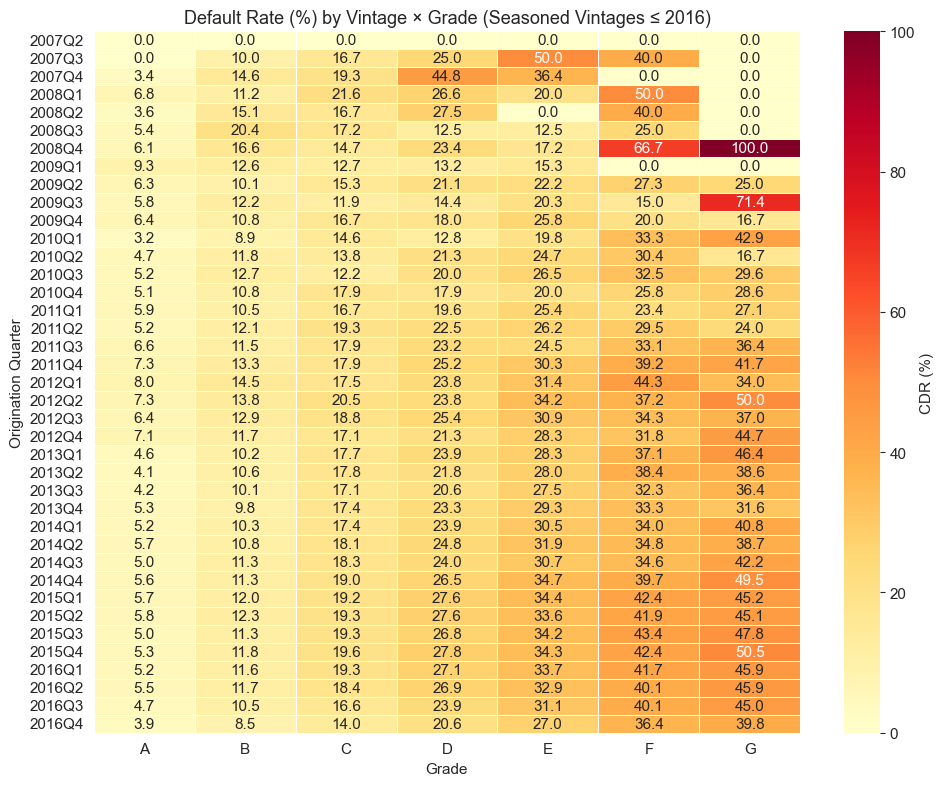

In [46]:
# ── Default rate by grade and vintage (heatmap) ────────────────
cdr_grade_vintage = (
    df.groupby(["issue_quarter", "grade"])
    .agg(count=("id", "count"), defaults=("is_default", "sum"))
)
cdr_grade_vintage["cdr"] = cdr_grade_vintage["defaults"] / cdr_grade_vintage["count"] * 100
cdr_pivot = cdr_grade_vintage["cdr"].unstack("grade").fillna(0)

# Only show vintages with enough seasoning (pre-2017)
seasoned = cdr_pivot.loc[cdr_pivot.index.str[:4].astype(int) <= 2016]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(seasoned, cmap="YlOrRd", annot=True, fmt=".1f", ax=ax,
            cbar_kws={"label": "CDR (%)"}, linewidths=0.5)
ax.set_title("Default Rate (%) by Vintage × Grade (Seasoned Vintages ≤ 2016)")
ax.set_ylabel("Origination Quarter")
ax.set_xlabel("Grade")
plt.tight_layout()
plt.show()


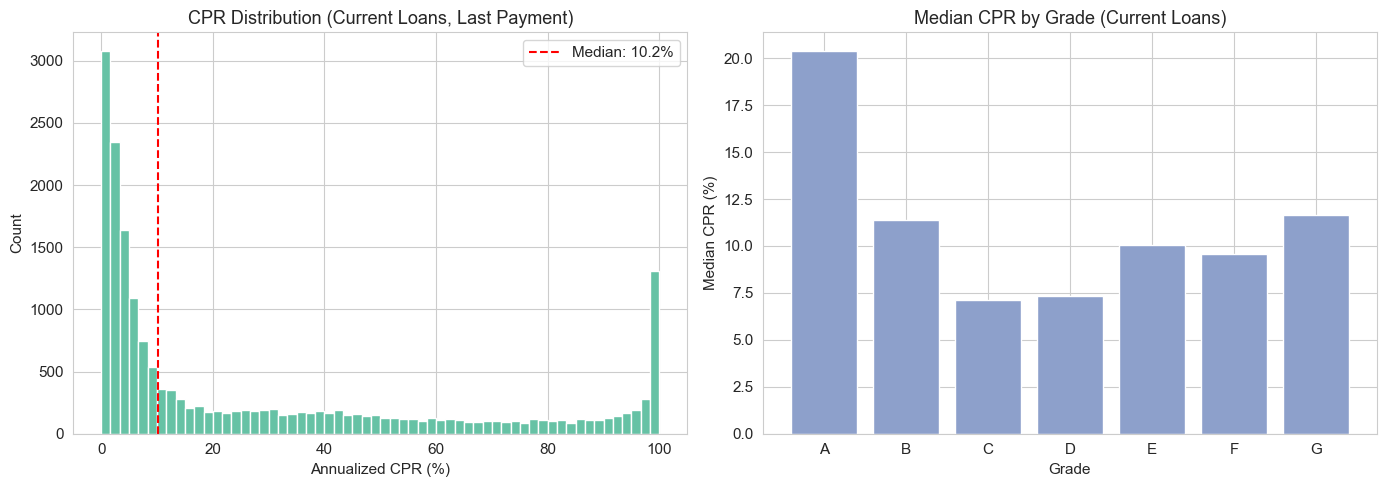

In [47]:
# ── CPR analysis for Current loans ─────────────────────────────
current = df[df["loan_status"] == "Current"].copy()
valid_cpr = current[(current["last_pmt_cpr"] > 0) & (current["last_pmt_cpr"] < 1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CPR distribution
axes[0].hist(valid_cpr["last_pmt_cpr"] * 100, bins=60, color=PALETTE[0], edgecolor="white")
axes[0].set_xlabel("Annualized CPR (%)")
axes[0].set_ylabel("Count")
axes[0].set_title("CPR Distribution (Current Loans, Last Payment)")
axes[0].axvline(valid_cpr["last_pmt_cpr"].median() * 100, color="red", ls="--",
                label=f"Median: {valid_cpr['last_pmt_cpr'].median()*100:.1f}%")
axes[0].legend()

# CPR by grade
cpr_by_grade = valid_cpr.groupby("grade")["last_pmt_cpr"].median() * 100
axes[1].bar(cpr_by_grade.index, cpr_by_grade.values, color=PALETTE[2])
axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Median CPR (%)")
axes[1].set_title("Median CPR by Grade (Current Loans)")

plt.tight_layout()
plt.show()


### 12d. Interest Rate & Income Analysis

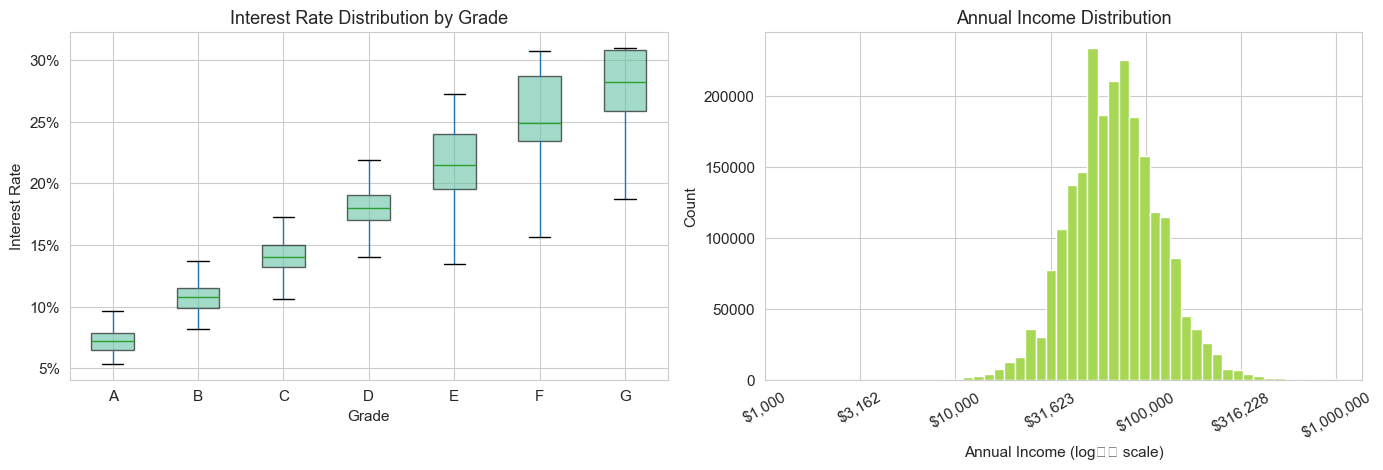

In [48]:
# ── Interest rate by grade (box plot) ──────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column="int_rate", by="grade", ax=axes[0],
           showfliers=False, patch_artist=True,
           boxprops=dict(facecolor=PALETTE[0], alpha=0.6))
axes[0].set_title("Interest Rate Distribution by Grade")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Interest Rate")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))
axes[0].get_figure().suptitle("")

# Income distribution (log scale)
inc_clean = df["annual_inc_clean"].dropna()
inc_clean = inc_clean[inc_clean > 0]
axes[1].hist(np.log10(inc_clean.clip(1000, 1_000_000)), bins=50,
             color=PALETTE[4], edgecolor="white")
axes[1].set_xlabel("Annual Income (log₁₀ scale)")
axes[1].set_ylabel("Count")
axes[1].set_title("Annual Income Distribution")
tick_vals = [3, 3.5, 4, 4.5, 5, 5.5, 6]
axes[1].set_xticks(tick_vals)
axes[1].set_xticklabels([f"${10**v:,.0f}" for v in tick_vals], rotation=30)

plt.tight_layout()
plt.show()


### 12e. Correlation Heatmap

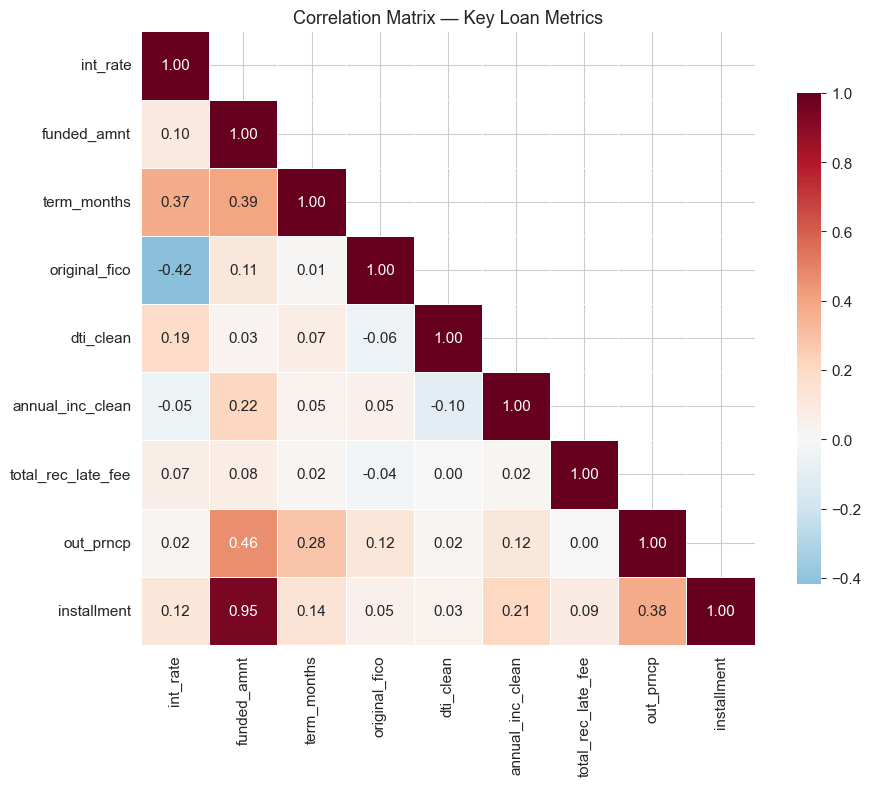

In [49]:
# ── Key metric correlations ────────────────────────────────────
corr_cols = [
    "int_rate", "funded_amnt", "term_months", "original_fico",
    "dti_clean", "annual_inc_clean", "total_rec_late_fee",
    "out_prncp", "installment"
]
corr_data = df[corr_cols].dropna()
corr_matrix = corr_data.corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, ax=ax, linewidths=0.5, square=True,
            cbar_kws={"shrink": 0.8})
ax.set_title("Correlation Matrix — Key Loan Metrics")
plt.tight_layout()
plt.show()


---
<a id="13-export"></a>
## 13. Export Clean Dataset


In [50]:
# ── Summary statistics ─────────────────────────────────────────
print(f"Final Clean Dataset")
print(f"{'='*60}")
print(f"  Rows:    {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")
print(f"\nLoan Status Breakdown:")
for status, count in df["loan_status"].value_counts().items():
    pct = count / len(df) * 100
    print(f"  {status:30s} {count:>10,}  ({pct:5.2f}%)")
print(f"\nKey Columns Added:")
new_cols = [
    "orig_exp_monthly_payment", "orig_exp_balance", "orig_exp_balance_diff",
    "last_pmt_smm", "last_pmt_cpr", "next_pmt_principal", "next_pmt_interest",
    "updated_remaining_term", "updated_maturity_date",
    "dti_clean", "annual_inc_clean", "original_fico", "latest_fico",
    "upb_lost", "joint_app_flag",
    "current_late_fee_flag", "curr_paid_late1_flag",
    "grace_to_paid_flag", "late1_to_paid_flag", "late2_to_paid_flag",
]
for c in new_cols:
    if c in df.columns:
        print(f"  ✓ {c}")


Final Clean Dataset
  Rows:    2,255,494
  Columns: 165

Loan Status Breakdown:
  Fully Paid                      1,081,285  (47.94%)
  Current                           873,773  (38.74%)
  Charged Off                       266,246  (11.80%)
  Late (31-120 days)                 21,365  ( 0.95%)
  In Grace Period                     8,436  ( 0.37%)
  Late (16-30 days)                   4,349  ( 0.19%)
  Default                                40  ( 0.00%)

Key Columns Added:
  ✓ orig_exp_monthly_payment
  ✓ orig_exp_balance
  ✓ orig_exp_balance_diff
  ✓ last_pmt_smm
  ✓ last_pmt_cpr
  ✓ next_pmt_principal
  ✓ next_pmt_interest
  ✓ updated_remaining_term
  ✓ updated_maturity_date
  ✓ dti_clean
  ✓ annual_inc_clean
  ✓ original_fico
  ✓ latest_fico
  ✓ upb_lost
  ✓ joint_app_flag
  ✓ current_late_fee_flag
  ✓ curr_paid_late1_flag
  ✓ grace_to_paid_flag
  ✓ late1_to_paid_flag
  ✓ late2_to_paid_flag


In [ ]:
# ── Save to CSV ────────────────────────────────────────────────
OUTPUT_PATH = "loan_data_clean.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved clean dataset to: {OUTPUT_PATH}")
print(f"File size: {__import__('os').path.getsize(OUTPUT_PATH) / 1e6:.0f} MB")


---

## Ideas for Next Steps

- **CPR estimation**: For loans that are no longer current, estimate historical CPR. For current loans, estimate future CPR using the last-payment decomposition above.
- **Prepayment turnover**: Identify loans that fully prepaid before the last scheduled payment (or while a meaningful % of UPB was still outstanding).
- **Recovery analysis**: Cross-reference fully-paid loans that were delinquent at some point to build out the transition/recovery matrix.
- **Cash flow model (Part 2)**: Use the clean dataset and CPR/CDR estimates as inputs to the monthly cash flow projection engine.
- **Scenario analysis (Part 3)**: Build base/stress/upside scenarios using the historical metrics computed here.
